In [68]:

import argparse
import os
import random
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.pyplot import imshow, imsave

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [35]:
# Root directory for dataset
dataroot = "Art/Uusi_Kansio"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1 # with mnist 1, other 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5001

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
MODEL_NAME = 'Conditional-DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [28]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset


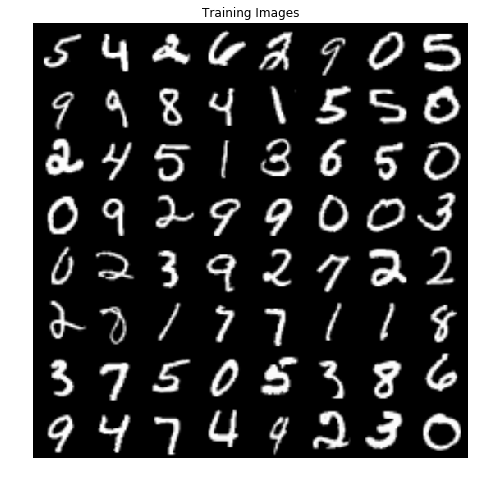

In [29]:

transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(image_size),
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))])

dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [31]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([image_size * 10, image_size * 10])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, image_size, image_size)
        result = y_hat.cpu().data.numpy()
        img[j*image_size:(j+1)*image_size] = np.concatenate([x for x in result], axis=-1)
    return img

In [58]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf,4,2,1,bias=False)
        
        self.convlabel = nn.Conv2d(condition_size, ndf,4,1,2,bias=False)
        
        
        
        self.convrest = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
        
        
        
    
    def forward(self, x, c=None):
        x = F.leaky_relu(self.conv1(x), 0.2)
        y = F.leaky_relu(self.convlabel(c), 0.2)
        x = torch.cat([x,y],1)
        print(x.shape)
        c = c.float()
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = torch.cat((x, c), 1) # v: (N, 794)
        print(x.shape)
        x = self.fc(x)
        
    
        #y_ = y_.view(y_.shape[0], 1, 28, 28) # (N, 1, 28, 28)
        #y_ = self.conv(y_)
        #y_ = y_.view(y_.size(0), -1)
        #y_ = self.fc(y_)
        
        return x

In [39]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size+condition_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, c):
        # x: (N, 100), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        v = torch.cat((x, c), 1) # v: (N, 110)
        y_ = self.fc(v)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_) # (N, 28, 28)
        return y_

In [59]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')
print(torch.__version__)

1.0.0


In [77]:
# Create label tensor.
fixed_y = torch.zeros(10, 1)

fixed_y_label_ = torch.zeros(batch_size, 10)
for idx, (images, labels) in enumerate(data_loader):
        labels = labels.view(-1,1)
        with torch.no_grad():
            
            fixed_y_label_.scatter_(1, labels.type(torch.LongTensor), 1)
            fixed_y_label_ = fixed_y_label_.view(-1, 10, 1, 1)
            fixed_y_label_ = Variable(fixed_y_label_.cuda())
        
            print(fixed_y_label_.shape)
        break


torch.Size([100, 10, 1, 1])


In [42]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0005, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999))


In [43]:
max_epoch = 30 # need more than 20 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [44]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [65]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        print(labels.shape)
        labels = labels.view(-1,1)
        print(labels)
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        #if (step % 100 == 0):
        #  print(y.shape)
        y = to_onehot(y).to(DEVICE)
        #if (step % 100 == 0):
        #  print(y.shape)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        #if step % 1000 == 0:
            #G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            #G.train()
            
        step += 1

torch.Size([100])
tensor([[0],
        [7],
        [5],
        [6],
        [0],
        [6],
        [0],
        [7],
        [1],
        [1],
        [1],
        [9],
        [3],
        [4],
        [7],
        [6],
        [5],
        [1],
        [2],
        [4],
        [5],
        [2],
        [2],
        [1],
        [2],
        [1],
        [8],
        [1],
        [4],
        [6],
        [3],
        [7],
        [5],
        [1],
        [4],
        [4],
        [7],
        [5],
        [1],
        [9],
        [6],
        [7],
        [6],
        [3],
        [2],
        [5],
        [3],
        [7],
        [9],
        [8],
        [5],
        [6],
        [0],
        [2],
        [1],
        [6],
        [7],
        [6],
        [2],
        [6],
        [6],
        [0],
        [5],
        [0],
        [8],
        [3],
        [1],
        [4],
        [7],
        [1],
        [0],
        [0],
        [6],
        [7],
        [3],
       

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 10, 4, 4], but got 2-dimensional input of size [100, 10] instead

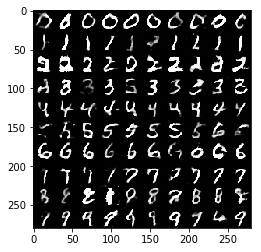

In [15]:
# generation to image
G.eval()
plt.figure(figuresize)
imshow(get_sample_image(G, n_noise), cmap='gray')

In [0]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [0]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_dc.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_dc.pth.tar')